In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from os.path import isfile
import pickle
from sklearn.metrics import r2_score
import re
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set_style(style='white')
sns.set_palette(sns.color_palette("Dark2"))

# **Анализ данных.**

In [2]:
def proceed_cat_str(in_cat: pd.Series):
    
    res_cat = in_cat.map(
        lambda x: str.upper(x).strip() if type(x) is str else np.NaN
    )

    return res_cat

In [3]:
src_train = pd.read_csv('./data/train.csv')
src_test = pd.read_csv('./data/test.csv')

In [4]:
src_df = pd.concat([src_train, src_test], ignore_index=True).reset_index()
src_df.drop(['index'], inplace=True, axis=1)
print(src_df.shape)

(1309, 12)


In [5]:
print(src_df.isna().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


Разберемся с названиями столбцов и что это значит.
1. Survived - выжил человек или нет.
2. Pclass - класс каюты.
3. Name - имя.
4. Sex - пол.
5. Age - возраст.
6. SibSp - количество родственников второго порядка. Муж, жена, братья, сестры.
7. Parch - количество родственников первоко порядка. Мать, отец, ребенок.
8. Ticket - номер билета.
9. Fare - цена билета.
10. Cabin - каюта.
11. Embarked - порт посадки. C - Cherbourg. Q - Queenstown. S - Southampton.

Пол кодируется очевидно.

In [6]:
sex_cat = {'male': 0, 'female': 1}
src_df['Sex'] = src_df['Sex'].map(sex_cat).astype('int')

Поскольку одно отсутствуещее значение цены билета принадлежит дядьке без родственников в третьем классе, присвоим ему среднее по третьему классу.

In [7]:
src_df['Fare'] = src_df['Fare'].fillna(src_df.groupby(['Pclass']).Fare.median()[3])

Пропущенное значение посадки можно просто нагуглить. Тупо в каком порту эти люди сели.

In [8]:
src_df['Embarked'] = src_df['Embarked'].fillna('S')

In [9]:
embarked_cat = dict(enumerate(src_df['Embarked'].astype('category').cat.categories))
src_df['Embarked'] = src_df['Embarked'].astype('category').cat.codes

Интересно, что есть нулевые цены билетов. Нужно взглянуть.

In [10]:
zero_fare_idx = src_df.loc[src_df['Fare'] == 0].index
print(src_df.loc[src_df['Fare'] == 0][['Pclass', 'Parch', 'SibSp']].sort_values(by=['Pclass']))

      Pclass  Parch  SibSp
1263       1      0      0
263        1      0      0
822        1      0      0
815        1      0      0
1157       1      0      0
633        1      0      0
806        1      0      0
277        2      0      0
413        2      0      0
466        2      0      0
481        2      0      0
674        2      0      0
732        2      0      0
179        3      0      0
271        3      0      0
302        3      0      0
597        3      0      0


Похоже, что это кто-то из гостей или команды, или что-то вроде. Поставлю среднее.

In [11]:
med_fare_1 = src_df.loc[src_df['Fare'] != 0].groupby(['Pclass']).Fare.median()[1]
med_fare_2 = src_df.loc[src_df['Fare'] != 0].groupby(['Pclass']).Fare.median()[2]
med_fare_3 = src_df.loc[src_df['Fare'] != 0].groupby(['Pclass']).Fare.median()[3]

fare_medians = {1: med_fare_1, 2: med_fare_2, 3: med_fare_3}

In [12]:
for index in zero_fare_idx:
    src_df.loc[index, 'Fare'] = fare_medians[src_df.loc[index, 'Pclass']]

Имена. Тут интересно. <br>
    <br>Mr. Обращение к мужчине любого возраста и семейного положения.
    <br>Master. Обращение к мальчику до 16 лет.
    <br>Mrs. Обращение к женщине, о которой нам точно известно что она замужем или вдова.
    <br>Miss. Mlle. Обращение к женщине, о которой нам точно известно что она не замужем.
    <br>Ms. Обращение к женщине, семейный статус которой нам не известен.
    <br>Rev. Обращение к священослужителю.
    <br>Dr. Человек с докторской степенью.
    <br>Sir. Lady. Don. Dona. Jonkheer. Countess. Mme. Дворянские титулы или люди "высокого" происхождения.
    <br>Capt. Col. Major. Офицерские звания.
    <br><br>Это может пригодиться для импутации возраста. Дополнительный фактор определения влияния цвета штанов на выживаемость.
    

In [13]:
def proceed_name(name: str):
    if 'MR.' in name:
        return 0
    elif 'MRS.' in name:
        return 1
    elif ('MISS.' in name) or ('MLLE.' in name):
        return 2
    elif 'MASTER.' in name:
        return 3
    elif 'REV.' in name:
        return 4
    elif 'MS.' in name:
        return 5
    elif 'DR.' in name:
        return 6
    elif ('SIR.' in name) or ('LADY.' in name) or ('DON.' in name) or ('DONA.' in name) or ('JONKHEER.' in name) or ('COUNTESS.' in name) or ('MME.' in name):
        return 7
    elif ('COL.' in name) or ('MAJOR.' in name) or ('CAPT.' in name):
        return 8
    else:
        return 9

In [14]:
src_df['Name'] = proceed_cat_str(src_df['Name']).map(proceed_name).astype('int')

Из билета, вероятно, тоже можно что-то извлечь. Но я не нашел однозначного алгоритма формирования номера. Поэтому выкину.

Каюта. Не бесполезный параметр. Но класс у нас уже есть, а как ТОЧНО определить каюту я не нашел. Можно пойти длинным путем и попробовать намайнить в интернете или поискать некую взаимосвязь между имеющимися данными и каютой. Но в данной конкретной работе я смысла в этом не вижу. Поэтому удалю.

In [15]:
src_df.drop(['Ticket', 'Cabin'], inplace=True, axis=1)

In [16]:
src_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,0,0,22.0,1,0,7.2500,2
1,2,1.0,1,1,1,38.0,1,0,71.2833,0
2,3,1.0,3,2,1,26.0,0,0,7.9250,2
3,4,1.0,1,1,1,35.0,1,0,53.1000,2
4,5,0.0,3,0,0,35.0,0,0,8.0500,2


In [17]:
print(src_df.isna().sum())

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64


Осталось импутировать возраст. Буду импутировать средним. 

Посмотрим как выглядит средний возраст по имени и классу. Сюда бы, конечно, еще бы родственников. Но датасет слишком маленький.

In [18]:
mean_age_by_name_and_class = src_df.loc[~src_df['Age'].isna()].groupby(['Name', 'Pclass']).mean()['Age']
print(mean_age_by_name_and_class)

Name  Pclass
0     1         41.450758
      2         32.346715
      3         28.318910
1     1         43.208955
      2         33.518519
      3         32.326531
2     1         30.131148
      2         20.717083
      3         17.360874
3     1          6.984000
      2          2.757273
      3          6.090000
4     2         41.250000
5     2         28.000000
6     1         45.600000
      2         38.500000
7     1         38.714286
8     1         54.714286
Name: Age, dtype: float64


Немного неудобно смотреть, но всё логично. Аристократы и офицеры в первом, ученые в первом-втором, женщины с неизветным статусом и священники во втором, ну и все остальные кому как повезло. <br>
Тут возможен вариант, что не будет соответствующего среднего, из-за малого датасета. Сделаю ещё среднее по полу и классу.

In [19]:
src_df['Family'] = src_df['SibSp'] + src_df['Parch']
mean_age_by_sex_and_class = src_df.loc[~src_df['Age'].isna()].groupby(['Sex', 'Pclass']).mean()['Age']
print(mean_age_by_sex_and_class)

Sex  Pclass
0    1         41.029272
     2         30.815380
     3         25.962264
1    1         37.037594
     2         27.499223
     3         22.185329
Name: Age, dtype: float64


Причина, по которой я считаю класс и пол важным, очень проста. Уклад жизни в начале двадцатого века был крайне сословен и патриархален. У высших и низжих сословий, мужчин, женщин и детей были четкие шаблоны поведения. 

In [20]:
age_na_idx = src_df.loc[src_df['Age'].isna()].index

In [21]:
for index in age_na_idx:
    name_v = int(src_df.loc[index, 'Name'])
    class_v = int(src_df.loc[index, 'Pclass'])
    sex_v = int(src_df.loc[index, 'Sex'])
    if name_v in mean_age_by_name_and_class:
        if class_v in mean_age_by_name_and_class[name_v]:
            age_m = np.int(mean_age_by_name_and_class[name_v][class_v])
            src_df.loc[index, 'Age'] = age_m
        else:
            age_m = np.int(mean_age_by_sex_and_class[sex_v][class_v])
            src_df.loc[index, 'Age'] = age_m
    else:
        age_m = np.int(mean_age_by_sex_and_class[sex_v][class_v])
        src_df.loc[index, 'Age'] = age_m
        


In [22]:
src_df.iloc[age_na_idx].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family
5,6,0.0,3,0,0,28.0,0,0,8.4583,1,0
17,18,1.0,2,0,0,32.0,0,0,13.0000,2,0
19,20,1.0,3,1,1,32.0,0,0,7.2250,0,0
26,27,0.0,3,0,0,28.0,0,0,7.2250,0,0
28,29,1.0,3,2,1,17.0,0,0,7.8792,1,0


In [23]:
print(src_df.isna().sum())

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
Family           0
dtype: int64


Попробую посмотреть на взаимосвязь каждого из параметров на выживание.

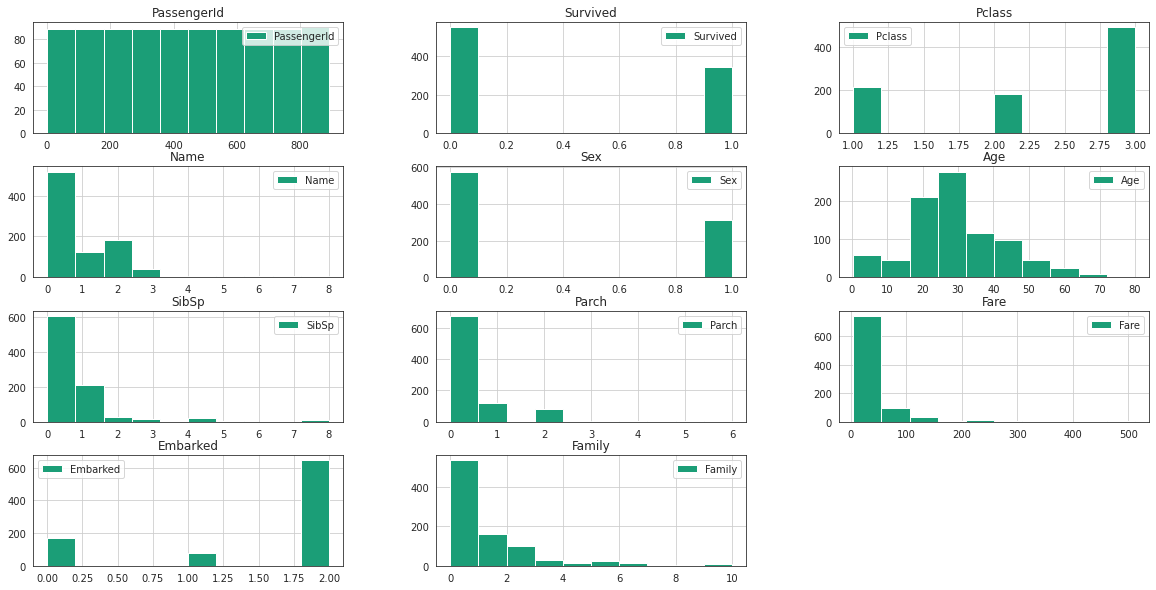

In [24]:
hist = src_df.loc[(~src_df['Survived'].isna())].hist(bins=10, figsize=(20, 10), legend=True)

In [25]:
src_df_clear = src_df[~src_df.isna()]
src_df_clear.drop(['PassengerId'], axis=1, inplace=True)

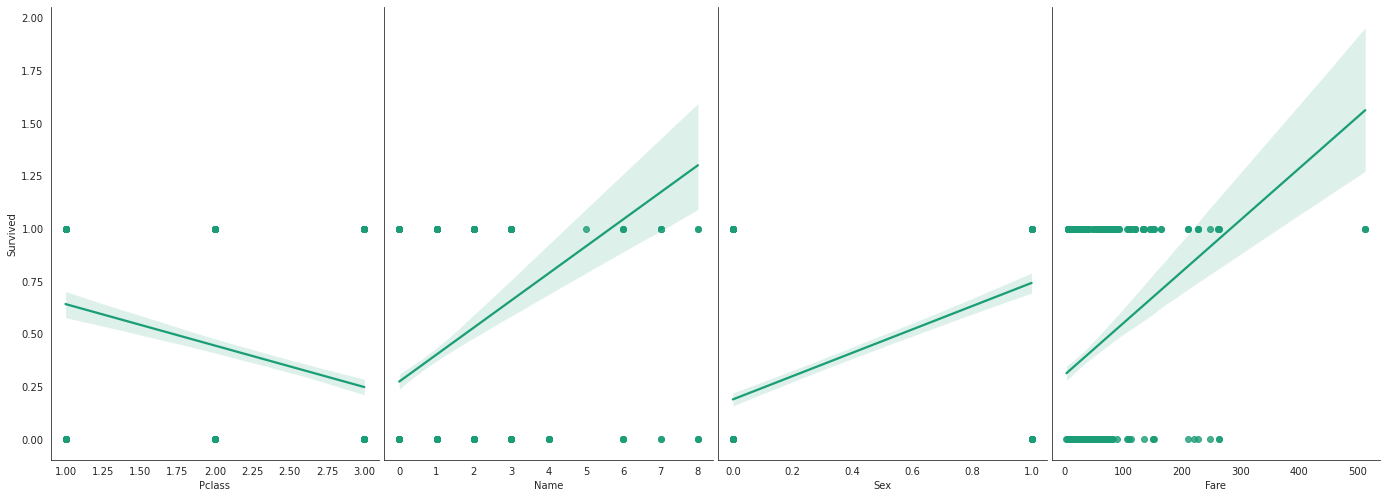

In [26]:
a = sns.pairplot(src_df_clear, x_vars=['Pclass', 'Name', 'Sex', 'Fare'], y_vars='Survived', height=7, aspect=0.7, kind='reg')

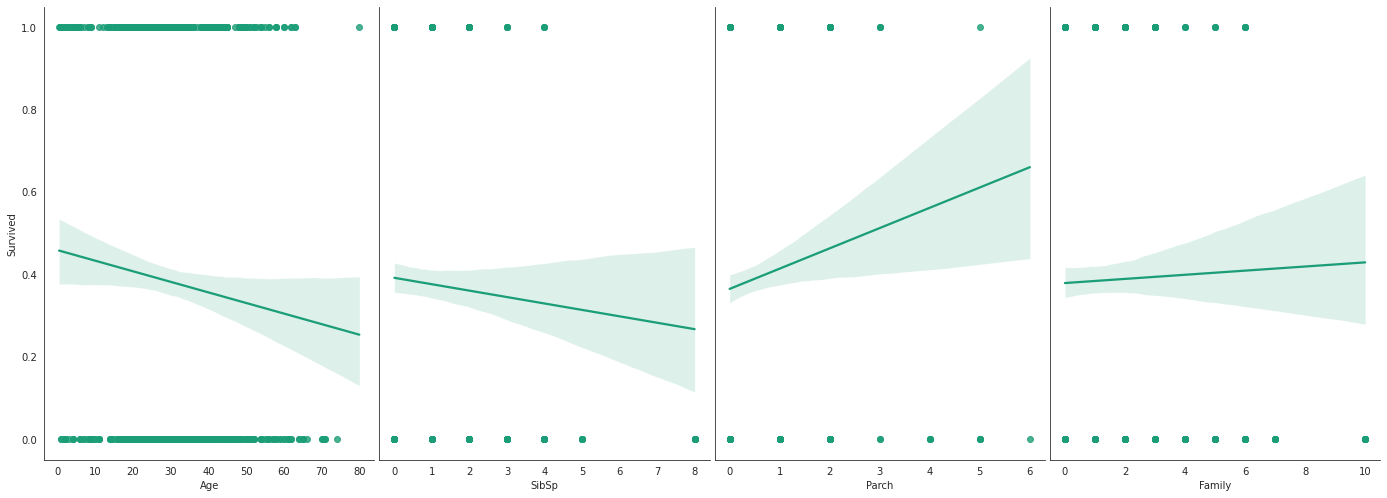

In [27]:
a = sns.pairplot(src_df_clear, x_vars=['Age', 'SibSp', 'Parch', 'Family'], y_vars='Survived', height=7, aspect=0.7, kind='reg')

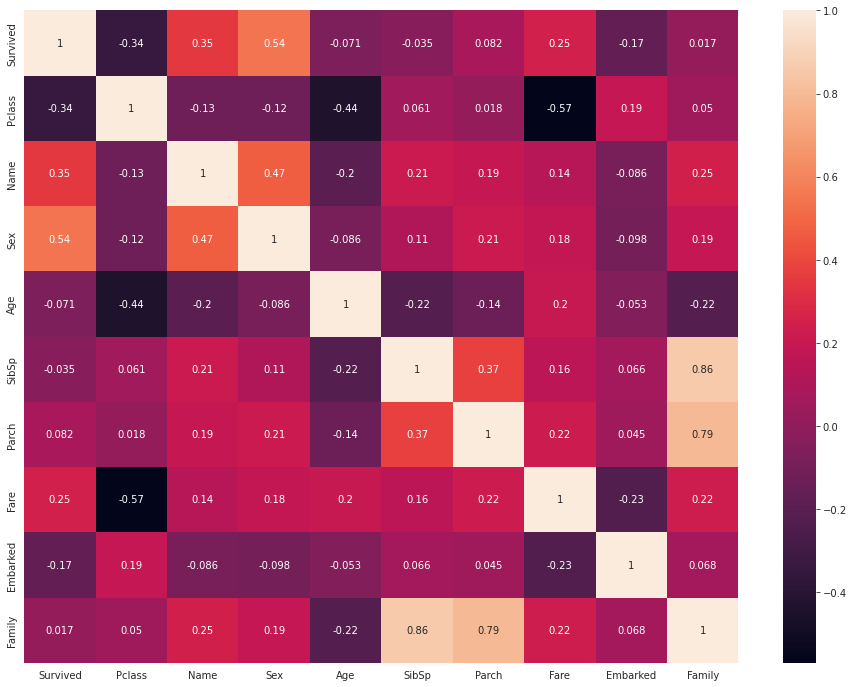

In [28]:
f, ax = plt.subplots(figsize=(16, 12))
a = sns.heatmap(src_df_clear.corr(), annot=True)

**Наблюдения**

Хорошие доверительные интервалы у пола и класса. Чем выше класс, тем выше шанс выжить, женщин выживает больше.

Общие закономерности:
1. Чем выше возраст, тем меньше шанс.
2. Наличие родственников второго порядка снижает шанс, первого-же наоборот - повышает. 
3. Сегментация родственников важна, поскольку количество родственников как таковое ничего не показвывает.
4. Естественные закономерности как цена билета, привелегированность класса имеют те же тенденции, что и класс каюты.

Мне не нравятся числовые значения класса. Получается, что числовое значение низкого класса выше чем у высокого.

In [29]:
src_df['Pclass'] = 1 / src_df['Pclass']

In [30]:
src_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family
0,1,0.0,0.333333,0,0,22.0,1,0,7.2500,2,1
1,2,1.0,1.000000,1,1,38.0,1,0,71.2833,0,1
2,3,1.0,0.333333,2,1,26.0,0,0,7.9250,2,0
3,4,1.0,1.000000,1,1,35.0,1,0,53.1000,2,1
4,5,0.0,0.333333,0,0,35.0,0,0,8.0500,2,0


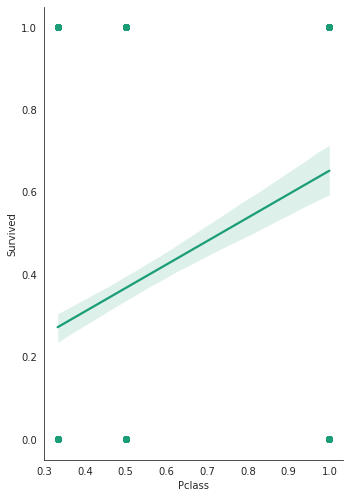

In [31]:
a = sns.pairplot(src_df, x_vars=['Pclass'], y_vars='Survived', height=7, aspect=0.7, kind='reg')

О! Так мне больше нравится. Сделаю то-же самое с возрастом и родственниками второго порядка.

In [32]:
#src_df['Age'] = 1 / src_df['Age'] - 1
src_df['SibSp'] = src_df['SibSp'].max() - src_df['SibSp']

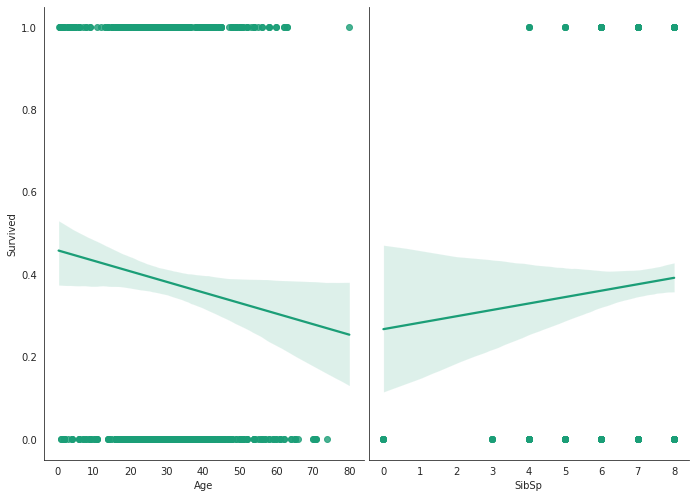

In [33]:
a = sns.pairplot(src_df, x_vars=['Age', 'SibSp'], y_vars='Survived', height=7, aspect=0.7, kind='reg')

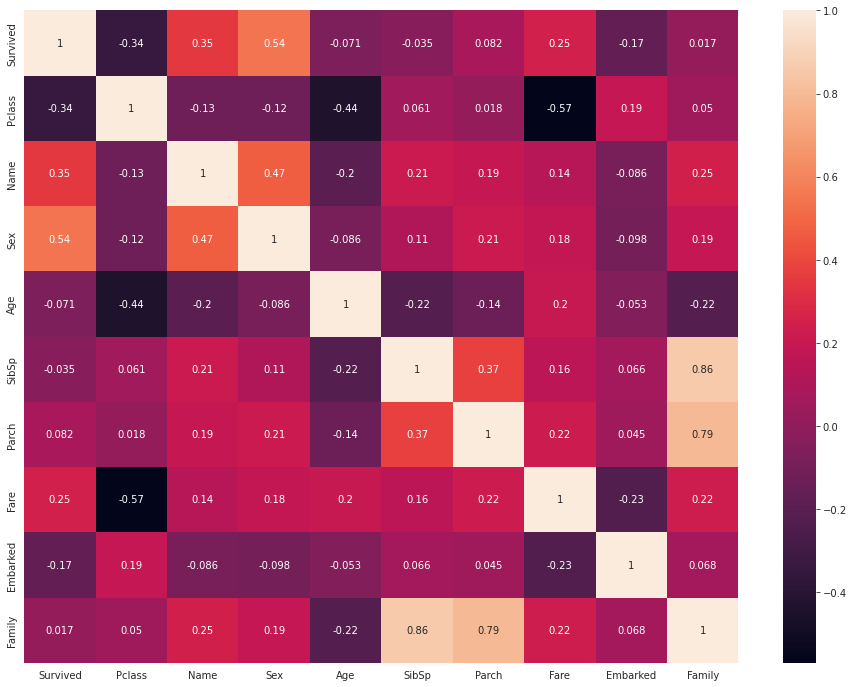

In [34]:
f, ax = plt.subplots(figsize=(16, 12))
a = sns.heatmap(src_df_clear.corr(), annot=True)

Попробую нормализовать.

In [35]:
src_df.drop(['PassengerId', 'Family'], inplace=True, axis=1)

In [36]:
#src_df.loc[:, src_df.columns != 'Survived'] = src_df.loc[:, src_df.columns != 'Survived'].apply(zscore)

In [37]:
src_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,0.333333,0,0,22.0,7,0,7.2500,2
1,1.0,1.000000,1,1,38.0,7,0,71.2833,0
2,1.0,0.333333,2,1,26.0,8,0,7.9250,2
3,1.0,1.000000,1,1,35.0,7,0,53.1000,2
4,0.0,0.333333,0,0,35.0,8,0,8.0500,2


# **Модель.**

In [38]:
work_df = src_df.loc[~src_df['Survived'].isna()]
X = work_df.loc[:, src_df.columns != 'Survived']
y = work_df['Survived'].ravel()

In [39]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.333333,0,0,22.0,7,0,7.2500,2
1,1.000000,1,1,38.0,7,0,71.2833,0
2,0.333333,2,1,26.0,8,0,7.9250,2
3,1.000000,1,1,35.0,7,0,53.1000,2
4,0.333333,0,0,35.0,8,0,8.0500,2


Легких путей я не ищу, поэтому почему бы в теме о логистической регресси не попробовать вобще все классификаторы? Как говорится в популярном ролике в ТикТок "... мне, но будет весело!"

**Logistic Regression**

In [47]:
lr_result = None

if isfile("./data/models/model_lr.pkl"):
    with open("./data/models/model_lr.pkl", "rb") as m_file:
        lr_result = pickle.load(m_file)
else:
    model_lr = LogisticRegression()
    
    X_ = X.apply(zscore)

    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = np.arange(0.5, 100, .5)
    lr_params = dict(solver=solvers,penalty=penalty,C=c_values)

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_lr, param_grid=lr_params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)

    lr_result = grid_search.fit(X_, y)
    
    with open("./data/models/model_lr.pkl", "wb") as m_file:
        pickle.dump(lr_result, m_file)

print("Best score is {:.4f}. ({})".format(lr_result.best_score_, lr_result.best_params_))

Best score is 0.7913. ({'C': 2.0, 'penalty': 'l2', 'solver': 'newton-cg'})


**Ridge Classifier**

In [49]:
rc_result = None

if isfile("./data/models/model_rc.pkl"):
    with open("./data/models/model_rc.pkl", "rb") as m_file:
        rc_result = pickle.load(m_file)
else:
    model_rc = RidgeClassifier()
    
    alpha = np.arange(0.1, 1, 0.05)

    rc_params = dict(alpha=alpha)
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_rc, param_grid=rc_params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    rc_result = grid_search.fit(X, y)
    
    with open("./data/models/model_rc.pkl", "wb") as m_file:
        pickle.dump(rc_result, m_file)

print("Best score is {:.4f}. ({})".format(rc_result.best_score_, rc_result.best_params_))

Best score is 0.7942. ({'alpha': 0.15000000000000002})


**K-Nearest Neighbors (KNN)**

In [51]:
knn_result = None

if isfile("./data/models/model_knn.pkl"):
    with open("./data/models/model_knn.pkl", "rb") as m_file:
        knn_result = pickle.load(m_file)
else:
    model_knn = KNeighborsClassifier()
    
    n_neighbors = range(1, 21, 2)
    weights = ['uniform', 'distance']
    metric = ['euclidean', 'manhattan', 'minkowski']

    knn_params = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_knn, param_grid=knn_params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    knn_result = grid_search.fit(X, y)
    
    with open("./data/models/model_knn.pkl", "wb") as m_file:
        pickle.dump(knn_result, m_file)

print("Best score is {:.4f}. ({})".format(knn_result.best_score_, knn_result.best_params_))

Best score is 0.7662. ({'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'})


**Support Vector Machine (SVM)**

In [52]:
svm_result = None

if isfile("./data/models/model_svm.pkl"):
    with open("./data/models/model_svm.pkl", "rb") as m_file:
        svm_result = pickle.load(m_file)
else:
    model_svm = SVC()
    
    kernel = ['linear', 'poly', 'rbf']
    C = np.concatenate((np.arange(1, 9, 1), np.arange(10, 45, 5), np.arange(50, 100, 10)), axis=0).flatten()
    gamma = ['scale', 'auto']
    degree = np.arange(1, 10, 1)
    class_weight = ['balanced', None]

    svm_params = dict(kernel=kernel,C=C,gamma=gamma, degree=degree, class_weight=class_weight)
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_svm, param_grid=svm_params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    svm_result = grid_search.fit(X, y)
    
    with open("./data/models/model_svm.pkl", "wb") as m_file:
        pickle.dump(svm_result, m_file)

print("Best score is {:.4f}. ({})".format(svm_result.best_score_, svm_result.best_params_))

KeyboardInterrupt: 

**Stochastic Gradient Boosting**

In [ ]:
gb_result = None

if isfile("./data/models/model_gb.pkl"):
    with open("./data/models/model_gb.pkl", "rb") as m_file:
        gb_result = pickle.load(m_file)
else:
    model_gb = GradientBoostingClassifier()
    
    n_estimators = np.concatenate((np.arange(10, 100, 10), np.arange(150, 500, 50), np.arange(600, 1000, 100)), axis=0).flatten()
    learning_rate = np.concatenate((np.arange(.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1.0, 0.1)), axis=0).flatten()
    subsample = np.arange(0.1, 1.0, 0.1)
    max_depth = np.arange(1, 10, 1)

    gb_params = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_gb, param_grid=gb_params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    gb_result = grid_search.fit(X, y)
    
    with open("./data/models/model_gb.pkl", "wb") as m_file:
        pickle.dump(gb_result, m_file)

print("Best score is {:.4f}. ({})".format(gb_result.best_score_, gb_result.best_params_))

**Random Forest**

In [ ]:
rf_result = None

if isfile("./data/models/model_rf.pkl"):
    with open("./data/models/model_rf.pkl", "rb") as m_file:
        rf_result = pickle.load(m_file)
else:
    model_rf = RandomForestClassifier()
    
    n_estimators = np.concatenate((np.arange(10, 100, 10), np.arange(150, 500, 50), np.arange(600, 1000, 100)), axis=0).flatten()
    max_features = ['sqrt', 'log2']

    rf_params = dict(n_estimators=n_estimators,max_features=max_features)
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_rf, param_grid=rf_params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    rf_result = grid_search.fit(X, y)
    
    with open("./data/models/model_rf.pkl", "wb") as m_file:
        pickle.dump(rf_result, m_file)

print("Best score is {:.4f}. ({})".format(rf_result.best_score_, rf_result.best_params_))

**Bagged Decision Trees (Bagging)**

In [ ]:
bc_result = None

if isfile("./data/models/model_bc.pkl"):
    with open("./data/models/model_bc.pkl", "rb") as m_file:
        bc_result = pickle.load(m_file)
else:
    model_bc = BaggingClassifier()
    
    n_estimators = np.concatenate((np.arange(10, 100, 10), np.arange(150, 500, 50), np.arange(600, 1000, 100)), axis=0).flatten()

    bc_params = dict(n_estimators=n_estimators)
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_bc, param_grid=bc_params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    bc_result = grid_search.fit(X, y)
    
    with open("./data/models/model_bc.pkl", "wb") as m_file:
        pickle.dump(bc_result, m_file)

print("Best score is {:.4f}. ({})".format(bc_result.best_score_, bc_result.best_params_))